In [1]:
%load_ext autoreload
%autoreload 2
from torch.utils.data import DataLoader
import torch 

device = 'cuda'

In [23]:
from pianogen.dataset.pianorolldataset import PianoRollDataset
from pianogen.dataset.tokenized import TokenizedPianoRollDataset
from pianogen.tokenizer import PianoRollTokenizer

pr_ds = PianoRollDataset('data', max_duration=32*150) # 150 bars
tokenizer = PianoRollTokenizer(n_pitch=88, n_velocity=32, token_seq_len=10240+1)
ds = TokenizedPianoRollDataset(pr_ds, tokenizer)
dl = DataLoader(ds,batch_size=1, shuffle=True, num_workers=8)

Creating dataset segment_len = 0
Created dataset with 2399 samples from 2570 songs


In [3]:
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from local_attention import LocalAttention
from pianogen.pe import binary_positional_encoding, sinusoidal_positional_encoding

class BinaryPositionalEncoding(nn.Module):
    '''
    Input: B, L (long)
    Output: B, L, D
    '''
    def __init__(self, dim:int, max_len:int):
        super().__init__()
        self.register_buffer('pos_encoding', binary_positional_encoding(max_len, dim).unsqueeze(0))

    def forward(self, pos: torch.Tensor):
        return torch.gather(self.pos_encoding.expand(pos.shape[0], -1, -1), 1, pos.unsqueeze(-1).expand(-1, -1, self.pos_encoding.shape[-1]))
    
class SinusoidalPositionalEncoding(nn.Module):
    '''
    Input: B, L (long)
    Output: B, L, D
    '''
    def __init__(self, dim:int, max_len:int):
        super().__init__()
        self.register_buffer('pos_encoding', sinusoidal_positional_encoding(max_len, dim).unsqueeze(0))

    def forward(self, pos: torch.Tensor):
        return torch.gather(self.pos_encoding.expand(pos.shape[0], -1, -1), 1, pos.unsqueeze(-1).expand(-1, -1, self.pos_encoding.shape[-1]))
    
class LocalMultiHeadAttention(nn.Module):
    '''
    Input: B, L, D
    Output: B, L, D
    '''
    def __init__(self, heads, dim, window_size, causal = False, dropout = 0.):
        super().__init__()
        assert dim % heads == 0, 'dimension must be divisible by number of heads'
        self.heads = heads
        self.to_qkv = nn.Linear(dim, dim * 3, bias = False)
        self.local_attn = LocalAttention(dim = dim // heads, window_size = window_size, causal = causal, dropout = dropout, autopad=True)

    def forward(self, x, mask = None):
        B, L, D = x.shape
        H = self.heads
        E = D // H

        qkv = self.to_qkv(x).chunk(3, dim = -1) # B, L, 3 * H, E
        q, k, v = map(lambda t: t.view(B, L, H, E).transpose(1, 2), qkv)

        out = self.local_attn(q, k, v, mask = mask)
        out = out.transpose(1, 2).reshape(B, L, D)
        return out

class LMHATransformerBlock(nn.Module):
    '''
    Input: B, L, D
    Output: B, L, D
    '''
    def __init__(self, dim, heads, window_size, ff_dim, dropout = 0., causal = False):
        super().__init__()
        self.attn = LocalMultiHeadAttention(heads = heads, dim = dim, window_size = window_size, dropout = dropout, causal = causal)
        self.ff = nn.Sequential(
            nn.Linear(dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, dim)
        )
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask = None):
        x = x + self.dropout(self.attn(self.norm1(x), mask = mask))
        x = x + self.dropout(self.ff(self.norm2(x)))
        return x

class SelectiveAttnTransformer(nn.Module):
    '''
    Token level attention is too expensive to apply on the whole sequence. This module instead learns a regular attention mask with
    a downsampled sequence (segment level), then transform it into the mask for the token level attention, by sparsely select the
    most important segments (the selection is not differentiable though).

    As such, token level attention is only applied on the selected segments, which is much faster.

    Input: B, n_token, n_feature
    '''

    def __init__(self, vocab_size, segment_len, dim = 256):
        super().__init__()

        self.segment_len = segment_len

        self.binary_pe_dim = 5
        self.sinusoidal_pe_dim = 123
        self.token_embedding = nn.Embedding(vocab_size, dim)
        self.binary_pos_encoding = BinaryPositionalEncoding(self.binary_pe_dim, 10240)
        self.sinusoidal_pos_encoding = SinusoidalPositionalEncoding(self.sinusoidal_pe_dim, 10240)

        self.in_local_attention = LMHATransformerBlock(heads=8, dim=dim, window_size=256, causal=True, dropout=0.1, ff_dim=256)
        self.downsample = nn.AvgPool1d(segment_len, stride=segment_len)
        self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=dim, nhead=8, dim_feedforward=1024, batch_first=True), num_layers=6)
        self.upsample = nn.Upsample(scale_factor=segment_len, mode='nearest')
        self.out_local_attention = LMHATransformerBlock(heads=8, dim=dim, window_size=256, causal=True, dropout=0.1, ff_dim=256)
        self.out_linear = nn.Linear(dim, vocab_size)

    def forward(self, x, pos):
        B, L = x.shape
        # x: B, L
        # pos: B, L+1
        x = self.token_embedding(x)

        pe = torch.cat([
            self.binary_pos_encoding(pos),
            self.sinusoidal_pos_encoding(pos),
        ], dim=-1) # B, L+1, D/2

        pe = torch.cat([
            pe[:, :-1], # pe of the input tokens
            pe[:, 1:]   # pe of the target tokens
        ], dim=2) # B, L, D

        x = x + pe
        
        
        x = self.in_local_attention(x)
        before_down = x

        # before entering the downsampled path, we need to make L % segment_len == 0

        if L >= self.segment_len: # if L < segment_len, we don't need to downsample

            x = x[:, :L - (L % self.segment_len)] # B, L - (L % segment_len), D

            x = self.downsample(x.transpose(1, 2)).transpose(1, 2)
            x = self.transformer(x)
            x = self.upsample(x.transpose(1, 2)).transpose(1, 2) # B, L - (L % segment_len), D

            # to avoid information leak, shift the data from the downsampled path right by segment_len-1
            x = F.pad(x, (0,0,self.segment_len-1, 0), 'constant', 0) # B, L+self.segment_len-1-(L % self.segment_len), D
            # crop redundant right-most stuff due to the right shift
            x = x[:, :L] # B, L, D
            # skip connection
            x = x + before_down

        x = self.out_local_attention(x)
        x = F.leaky_relu(x)
        x = self.out_linear(x)
        return x
        

class PianoRollGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.in_linear = nn.Linear(200, 256)
        self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=256, nhead=8, dim_feedforward=1024, batch_first=True), num_layers=6)
        self.out_linear = nn.Linear(256, 121)

    def forward(self, x):
        x = self.in_linear(x)
        x = self.transformer(x, mask = nn.Transformer.generate_square_subsequent_mask(x.shape[1]).to(x.device), is_causal = True)
        x = self.out_linear(x)
        return x
        


In [4]:
model = SelectiveAttnTransformer(len(tokenizer.vocab),128,256)
crit = nn.CrossEntropyLoss(ignore_index=0)
opt = Adam(model.parameters(), lr=1e-4)
print('number of parameters:', sum(p.numel() for p in model.parameters())/1e6, 'M')

number of parameters: 5.460604 M


In [24]:

from tqdm import tqdm
from pianogen.data.pianoroll import Note, PianoRoll

    

    
def inference(file_path:str):
    model.eval()
    #tokens = [{'type':'start'}]
    tokens = ds.tokenizer.tokenize(ds.ds.get_piano_roll(0).slice(0,65))[:2]

    last_token = tokens[-1]

    #length = 10240
    length = 200
    for _ in tqdm(range(length)):
        
        indices = tokenizer.vocab.tokens_to_indices(tokens)[:-1]
        pos = tokenizer.get_frame_indices(tokens)
        #output_mask = tokenizer.get_output_mask(tokens[:-1])

        indices = indices.unsqueeze(0).to(device)
        pos = pos.unsqueeze(0).to(device)

        logits = model(indices,pos).squeeze(0)[-1].detach().cpu()
        decoded = tokenizer.sample_from_logits(logits, last_token)
        tokens.append(decoded)
        last_token = decoded

        if decoded['type'] == 'end':
            break

    tokenizer.detokenize(tokens).to_midi(file_path)
    print(tokens)
model.to(device)
inference('output/output.mid')


100%|██████████| 200/200 [00:01<00:00, 143.07it/s]

[{'type': 'start'}, {'type': 'pitch', 'value': 19}, {'value': 16, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 50, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 55, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 43, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 34, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 51, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 36, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 53,

In [34]:
# train
import time
from tqdm import tqdm


model.to(device)
crit.to(device)

model.train()

for epoch in range(100):
    tq = tqdm(dl)
    for i, batch in enumerate(tq):
        batch = {k:v.to(device) for k,v in batch.items()}
        opt.zero_grad()
        out = model(batch['indices'][:,:-1], batch['pos'])
        out.retain_grad()
        loss = crit((out+batch['output_mask']).transpose(1,2), batch['indices'][:,1:])
        loss.backward()
        opt.step()
        if i % 10 == 0:
            # print the loss to tqdm
            #temp = torch.cuda.temperature()
            temp = 0
            tq.set_postfix(batch = i, loss= loss.item(), gpu_temp=temp)

            if temp > 65:
                print("GPU temperature is too high. Slowin down.", temp)
                time.sleep(0.1)
        
                    
        if torch.isnan(loss):
            raise ValueError("Loss is NaN")
        
        if loss < 5:
            small_loss_out = out.detach().cpu()
            small_loss_out_grad = out.grad.detach().cpu()
            small_loss_batch = batch
        if loss > 100:
            large_loss_out = out.detach().cpu()
            large_loss_out_grad = out.grad.detach().cpu()
            large_loss_batch = batch
    
    inference(f'./output/output_{epoch}_{i}.mid')
    torch.save(model.state_dict(), f'./model_{epoch}.pth')
    torch.save(opt.state_dict(), f'./opt_{epoch}.pth')
    



  9%|▊         | 204/2399 [00:11<02:07, 17.20it/s, batch=200, gpu_temp=0, loss=1.72]


KeyboardInterrupt: 

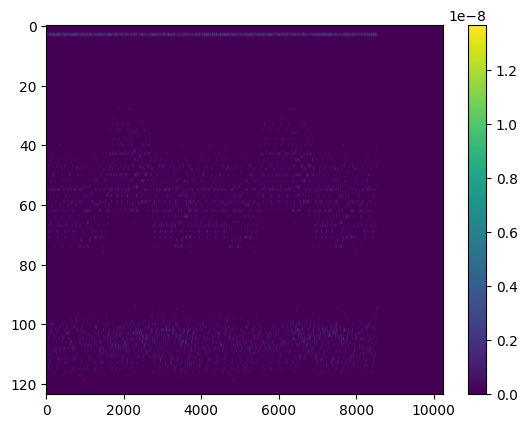

In [35]:
from matplotlib import pyplot as plt

plt.imshow((small_loss_out_grad[0]**2).T, aspect='auto')
plt.colorbar()

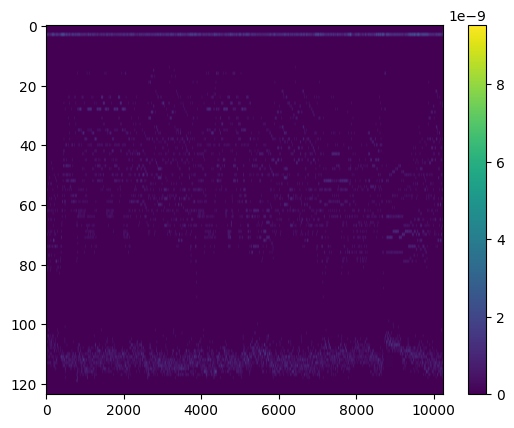

In [36]:
plt.imshow((large_loss_out_grad[0]**2).T, aspect='auto')
plt.colorbar()

In [37]:
large_loss_batch['indices'][0,-250:].cpu().numpy()

array([ 55, 116,  58, 115,  63, 114,  67, 117,   3,   3,  39, 112,  43,
       112,   3,   3,  27, 109,   3,   3,  31, 110,  39, 112,  43, 113,
        58, 114,  70, 115,   3,   3,  29, 114,  57, 115,  60, 114,  65,
       113,  69, 117,   3,   3,  41, 112,  45, 113,   3,   3,  29, 113,
         3,   3,  41, 113,  45, 114,  65, 114,   3,   3,  22, 115,  62,
       116,  65, 115,  70, 114,  74, 118,   3,   3,  34, 113,  38, 112,
         3,   3,  22, 113,   3,   3,  34, 112,  38, 109,   3,   3,  22,
       111,   3,   3,  34, 111,  38, 110,   3,   3,  23, 113,  62, 117,
        74, 117,   3,   3,  35, 110,   3,   3,  24, 114,  36, 114,  60,
       115,  72, 117,   3,   3,  60, 114,  72, 114,   3,  60, 111,  72,
       114,   3,  43, 113,  48, 110,  51, 116,  58, 115,  70, 116,   3,
        51, 111,   3,   3,  72, 112,   3,  39, 111,  43, 114,  48, 113,
        55, 116,  67, 116,   3,  36, 113,   3,  36, 113,   3,   3,  24,
       114,   3,   3,  65, 115,   3,   3,  26, 115,  38, 115,  6

In [ ]:
for i, batch in enumerate(tq):
    break

In [ ]:
device

'cpu'

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
from torch.utils.data import DataLoader, Dataset
ds = [1,2,3,4,5,36,4,1]
dl = DataLoader(ds, batch_size=2, shuffle=True, num_workers=2)
for b in dl:
    print(b)

tensor([4, 4])
tensor([ 2, 36])
tensor([5, 1])
tensor([3, 1])
